In [1]:
import torch
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from backpack import backpack, extend
from backpack.extensions import DiagGGNExact

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils_2d import *

import copy

from tqdm import tqdm

from copy import deepcopy

import time

sns.set()

torch.manual_seed(42)
torch.cuda.is_available()

True

# Continual Learning Experiments

### The following experiments are to examine the effects of some different approaches to continual learning using an artificial 2D dataset that can provide some visual intuition ( which as is well-known will likely not hold in higher dimensions). We beginning by generating some data.

### The first & second data set consist of 4 Gaussian blobs, placed into 2 groups. The idea being that the first data set is used to train an initial model for binary classification, then the second data set is used to either train a new model or to improve the previous model. The different data sets are representing different, but related 'tasks'.

### Note the second data set has some large differences from the first.

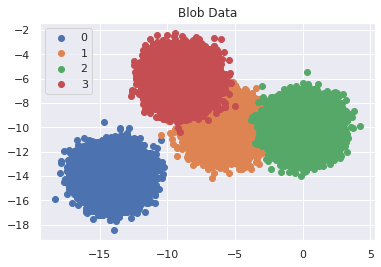

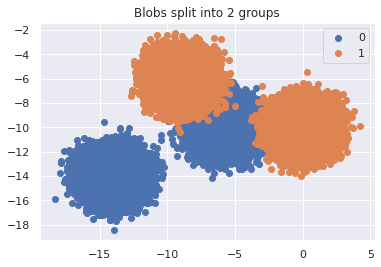

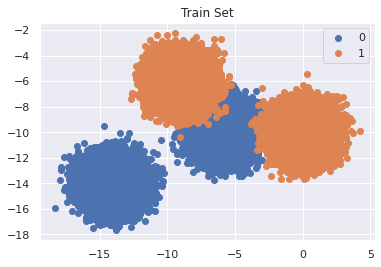

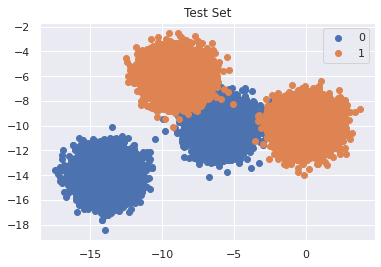

In [2]:
X_train, X_test, y_train, y_test = get_binary_blobs(centers = [[-14, -14],[-6,-10],[0,-10],[-9,-6]])

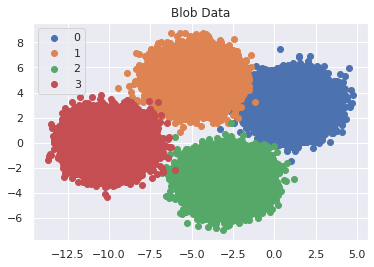

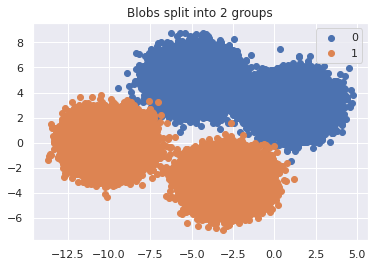

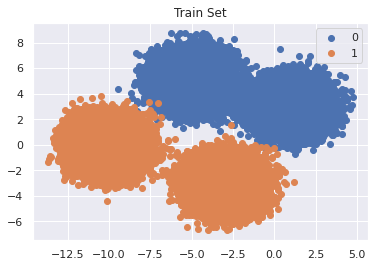

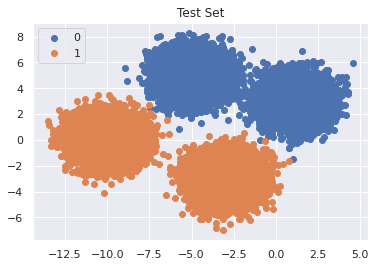

In [3]:
X_tr2, X_t2, y_tr2, y_t2 = get_binary_blobs(centers = [[1,3],[-5,5],[-3,-3],[-10,0]])

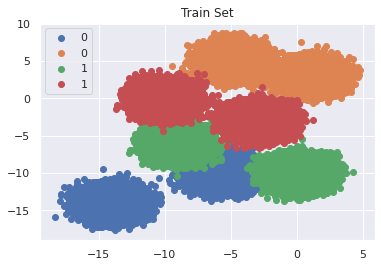

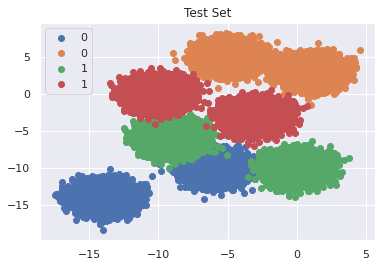

In [4]:
for i in range(2):
    plt.scatter(X_train[y_train == i,0], X_train[y_train == i,1], label = i)
    plt.scatter(X_tr2[y_tr2 == i,0], X_tr2[y_tr2 == i,1], label = i)
plt.title("Train Set")
plt.legend()
plt.show()

for i in range(2):
    plt.scatter(X_test[y_test == i,0], X_test[y_test == i,1], label = i)
    plt.scatter(X_t2[y_t2 == i,0], X_t2[y_t2 == i,1], label = i)
plt.title("Test Set")
plt.legend()
plt.show()

In [5]:
def get_tensor_dataset(X, y):
    y = y.reshape(-1,1)
    return TensorDataset(torch.Tensor(X), torch.Tensor(y))

def train_model(X, y, model = None, optimizer = None):
    if model is None:
        model = nn.Sequential(
                nn.Linear(2, 20),
                nn.ReLU(),
                nn.Linear(20, 10),
                nn.ReLU(),
                nn.Linear(10, 1),
                nn.Sigmoid())
    
    use_gpu = torch.cuda.is_available()
    
    if use_gpu:
        model.cuda()

    batch_size = 256
    data_loader = torch.utils.data.DataLoader(get_tensor_dataset(X, y), batch_size = batch_size,
                                          shuffle = True, num_workers = 2)
    
    criterion = nn.MSELoss()
    
    if optimizer is None:
        optimizer = optim.AdamW(model.parameters())
    
    for epoch in range(20):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(data_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

        print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss / 2000))

    print('Finished Training')
    
    return model

def train_then_plot(X, y, model = None, optimizer = None):
    start = time.perf_counter()
    net = train_model(X, y, model, optimizer)
    stop = time.perf_counter()
    print(f"Train time: {stop - start} sec")
    plot_decision_boundary(net, X_test, y_test)
    plot_decision_boundary(net, X_t2, y_t2)
    plot_decision_boundary(net, np.concatenate([X_test, X_t2]), np.concatenate([y_test, y_t2]))
    return net

# Initial Training

### The initial model is trained on the first data set and performs quite well on the first test set. However, it does quite poorly on the unseen 2nd data set test set.

[1,   293] loss: 0.021
[2,   293] loss: 0.011
[3,   293] loss: 0.008
[4,   293] loss: 0.006
[5,   293] loss: 0.005
[6,   293] loss: 0.004
[7,   293] loss: 0.003
[8,   293] loss: 0.002
[9,   293] loss: 0.002
[10,   293] loss: 0.002
[11,   293] loss: 0.001
[12,   293] loss: 0.001
[13,   293] loss: 0.001
[14,   293] loss: 0.001
[15,   293] loss: 0.001
[16,   293] loss: 0.001
[17,   293] loss: 0.001
[18,   293] loss: 0.001
[19,   293] loss: 0.001
[20,   293] loss: 0.001
Finished Training
Train time: 20.20050124503905 sec
AUC: 0.9998930133266956
MSE: 0.004552073462534617


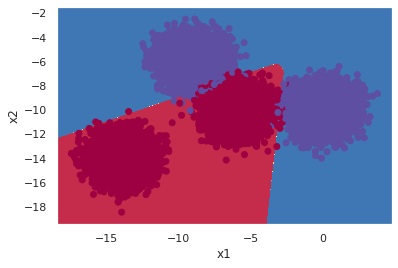

AUC: 0.03304630554875475
MSE: 0.48006037600082935


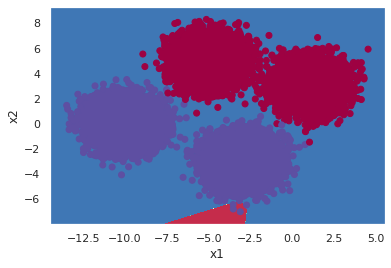

AUC: 0.633719589881347
MSE: 0.24230622473168198


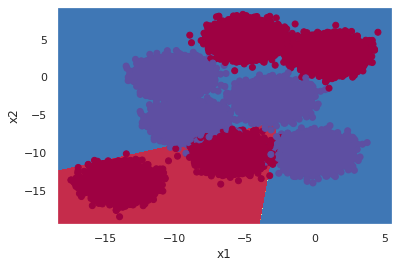

In [22]:
first_net = train_then_plot(X_train, y_train)

# Naive Transfer Learning

### Transfer learning is applied by initializing a new network with the weights of the initial network, then it is trained on the second data set. While it does quite well on the second data set, it has catastrophically forgotten all relevant knowledge from the first data set. 

[1,   293] loss: 0.030
[2,   293] loss: 0.001
[3,   293] loss: 0.000
[4,   293] loss: 0.000
[5,   293] loss: 0.000
[6,   293] loss: 0.000
[7,   293] loss: 0.000
[8,   293] loss: 0.000
[9,   293] loss: 0.000
[10,   293] loss: 0.000
[11,   293] loss: 0.000
[12,   293] loss: 0.000
[13,   293] loss: 0.000
[14,   293] loss: 0.000
[15,   293] loss: 0.000
[16,   293] loss: 0.000
[17,   293] loss: 0.000
[18,   293] loss: 0.000
[19,   293] loss: 0.000
[20,   293] loss: 0.000
Finished Training
Train time: 17.339145222998923 sec
AUC: 0.5
MSE: 0.50316


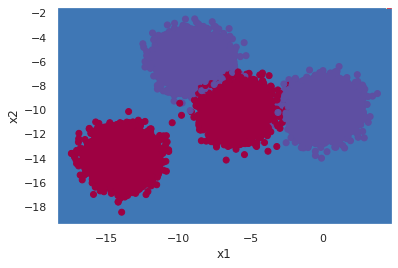

AUC: 0.9999983999360895
MSE: 0.0002747575177477952


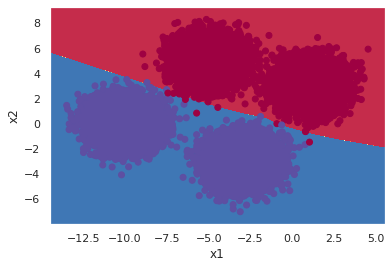

AUC: 0.6893160801385994
MSE: 0.25171737875887384


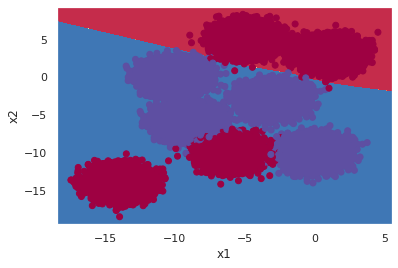

In [7]:
first_transfer_net = train_then_plot(X_tr2, y_tr2, copy.deepcopy(first_net))

# Second Training

### As a baseline, we examine the performance of a network with random initialization that is trained only on the second data set. Interestingly, the naive transfer learned network does better.

[1,   293] loss: 0.006
[2,   293] loss: 0.000
[3,   293] loss: 0.000
[4,   293] loss: 0.000
[5,   293] loss: 0.000
[6,   293] loss: 0.000
[7,   293] loss: 0.000
[8,   293] loss: 0.000
[9,   293] loss: 0.000
[10,   293] loss: 0.000
[11,   293] loss: 0.000
[12,   293] loss: 0.000
[13,   293] loss: 0.000
[14,   293] loss: 0.000
[15,   293] loss: 0.000
[16,   293] loss: 0.000
[17,   293] loss: 0.000
[18,   293] loss: 0.000
[19,   293] loss: 0.000
[20,   293] loss: 0.000
Finished Training
Train time: 17.618904043978546 sec
AUC: 0.18707963880976522
MSE: 0.5031599896232911


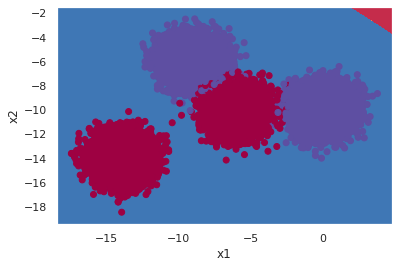

AUC: 0.9999961534463593
MSE: 0.00029859749318382223


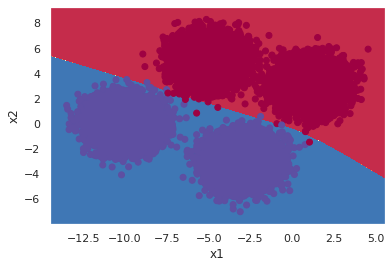

AUC: 0.5469425117965832
MSE: 0.2517292935582375


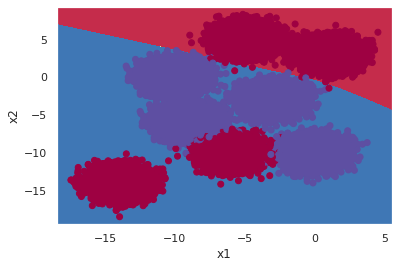

In [8]:
second_net = train_then_plot(X_tr2, y_tr2)

# Combined Data Training

### As an upper bound baseline for overall performance, we train a network utilizing all of the data. Continual learning strategies might aim to approximate this as closely as possible, without having to use all of the data from the first data set.

### As expected, it shows excellent performance on both tasks.

[1,   586] loss: 0.020
[2,   586] loss: 0.002
[3,   586] loss: 0.001
[4,   586] loss: 0.001
[5,   586] loss: 0.001
[6,   586] loss: 0.001
[7,   586] loss: 0.001
[8,   586] loss: 0.001
[9,   586] loss: 0.001
[10,   586] loss: 0.001
[11,   586] loss: 0.001
[12,   586] loss: 0.001
[13,   586] loss: 0.001
[14,   586] loss: 0.001
[15,   586] loss: 0.001
[16,   586] loss: 0.001
[17,   586] loss: 0.001
[18,   586] loss: 0.001
[19,   586] loss: 0.001
[20,   586] loss: 0.001
Finished Training
Train time: 35.12909352700808 sec
AUC: 0.9999047129940084
MSE: 0.0033882810072127195


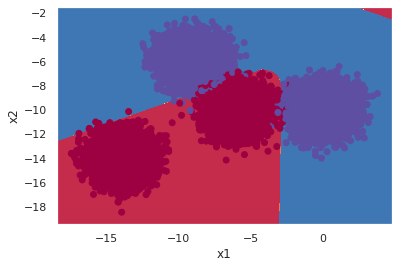

AUC: 0.9999926909080573
MSE: 0.00036578940374831575


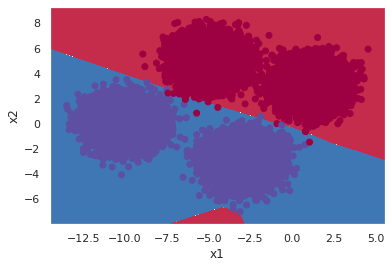

AUC: 0.9999658498359605
MSE: 0.0018770352054805176


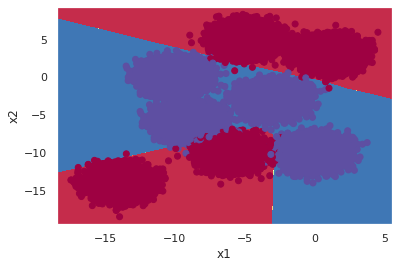

In [9]:
both_net = train_then_plot(np.concatenate([X_train, X_tr2]), np.concatenate([y_train, y_tr2]))

# Transfer Learning w/ Decreased Learning Rate

### One strategy used in transfer learning to prevent catastrophic forgetting, is to reduce the learning weight, so that the weights will not 'move' too far away from the first network. In this particular case, this strategy does not work so well.

[1,   293] loss: 0.072
[2,   293] loss: 0.072
[3,   293] loss: 0.072
[4,   293] loss: 0.072
[5,   293] loss: 0.072
[6,   293] loss: 0.072
[7,   293] loss: 0.071
[8,   293] loss: 0.071
[9,   293] loss: 0.070
[10,   293] loss: 0.070
[11,   293] loss: 0.068
[12,   293] loss: 0.067
[13,   293] loss: 0.063
[14,   293] loss: 0.058
[15,   293] loss: 0.047
[16,   293] loss: 0.035
[17,   293] loss: 0.029
[18,   293] loss: 0.026
[19,   293] loss: 0.024
[20,   293] loss: 0.023
Finished Training
Train time: 13.831407288002083 sec
AUC: 0.6531087491309013
MSE: 0.47266711713494913


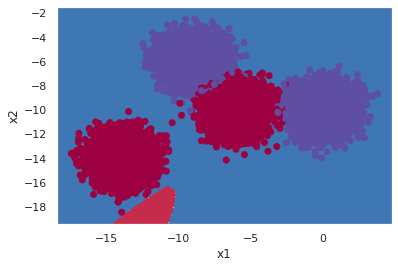

AUC: 0.9950030100082271
MSE: 0.15054315785701744


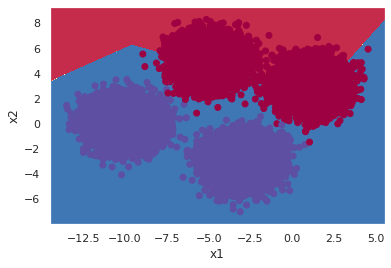

AUC: 0.6639216490240739
MSE: 0.3116051374959833


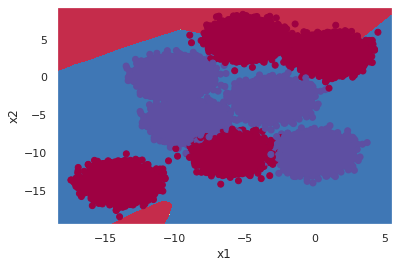

In [12]:
copy_first = copy.deepcopy(first_net)
slow_sgd = optim.SGD(copy_first.parameters(), weight_decay = 0.01, lr = 0.001)
slow_transfer = train_then_plot(X_tr2, y_tr2, copy_first, slow_sgd)

# Freezing Weights

### Another common strategy is to freeze the weights in the early layers of the network. TOnce again, this doesn't work so well for this case.

[1,   293] loss: 0.061
[2,   293] loss: 0.028
[3,   293] loss: 0.018
[4,   293] loss: 0.017
[5,   293] loss: 0.016
[6,   293] loss: 0.015
[7,   293] loss: 0.014
[8,   293] loss: 0.013
[9,   293] loss: 0.013
[10,   293] loss: 0.012
[11,   293] loss: 0.011
[12,   293] loss: 0.011
[13,   293] loss: 0.010
[14,   293] loss: 0.010
[15,   293] loss: 0.009
[16,   293] loss: 0.009
[17,   293] loss: 0.008
[18,   293] loss: 0.008
[19,   293] loss: 0.008
[20,   293] loss: 0.007
Finished Training
Train time: 16.323169744980987 sec
AUC: 0.0041669408376177166
MSE: 0.754062133548409


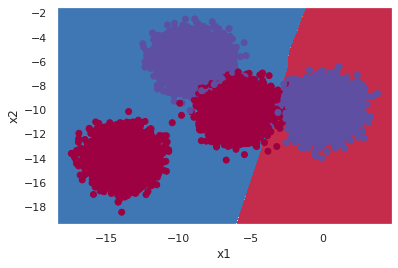

AUC: 0.9690754527993659
MSE: 0.049631641869061424


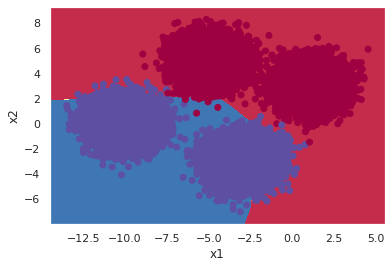

AUC: 0.3674772491232754
MSE: 0.4018468877087352


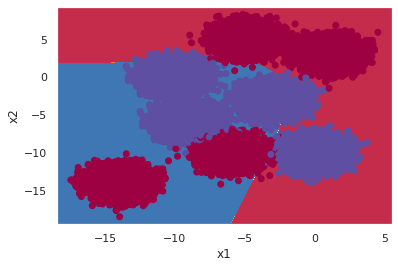

In [52]:
copy_first = copy.deepcopy(first_net)
for name, param in copy_first.named_parameters():
    if name in ["0.weight", "0.bias", "2.weight", "2.bias"]:
        param.requires_grad = False
freeze_first_optimizer = optim.AdamW(copy_first.parameters())
freeze_first_transfer = train_then_plot(X_tr2, y_tr2, copy_first, freeze_first_optimizer)

# Elastic Weight Consolidation

### A regularization based technique, which has shown some very encouraging performance in the realm of continual learning, came from researchers at Deep Mind, and is known as Elastic Weight Consolidation (EWC). The idea is to penalize changes in parameters based on the level of importance for that parameter. The original paper uses a diagnonal approximation of the FIsher Information Matrix to provide a notion of weight importance. This idea is both theoretically motivated and cleanly implemented. A winning combo!

### The code below is largely derived from:
### https://github.com/moskomule/ewc.pytorch

### For more details see:
### https://www.pnas.org/content/114/13/3521

In [19]:
 class EWC(object):
    def __init__(self, model: nn.Module, dataset: list):

        self.model = model
        self.dataset = dataset

        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}
        self._means = {}
        self._precision_matrices = self._diag_fisher()

        for n, p in deepcopy(self.params).items():
            self._means[n] = p.data
            
        if torch.cuda.is_available():
            model.cuda()

    def _diag_fisher(self):
        precision_matrices = {}
        for n, p in deepcopy(self.params).items():
            p.data.zero_()
            precision_matrices[n] = p.data

        self.model.eval()
        for input, label in self.dataset:
            if torch.cuda.is_available():
                input, label = input.cuda(), label.cuda()
            self.model.zero_grad()
            output = self.model(input)
            loss = F.mse_loss(output, label)
            loss.backward()

            for n, p in self.model.named_parameters():
                precision_matrices[n].data += p.grad.data ** 2 / len(self.dataset)

        precision_matrices = {n: p for n, p in precision_matrices.items()}
        return precision_matrices

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            _loss = self._precision_matrices[n] * (p - self._means[n]) ** 2
            loss += _loss.sum()
        return loss

def ewc_train(model: nn.Module, optimizer: torch.optim, data_loader: torch.utils.data.DataLoader,
              ewc: EWC, importance: float):
    if torch.cuda.is_available():
        model.cuda()
    model.train()
    
    epoch_loss = 0
    for input, target in data_loader:
        if torch.cuda.is_available():
            input, target = input.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(input)
        loss = F.mse_loss(output, target) + importance * ewc.penalty(model)
        epoch_loss += loss
        loss.backward()
        optimizer.step()
    return epoch_loss / len(data_loader)

In [61]:
data_loader = torch.utils.data.DataLoader(get_tensor_dataset(X_train, y_train), batch_size = 256,
                                          shuffle = True, num_workers = 2)

data_loader2 = torch.utils.data.DataLoader(get_tensor_dataset(X_tr2, y_tr2), batch_size = 256,
                                          shuffle = True, num_workers = 2)

ewc = EWC(first_net, data_loader.dataset)

ewc_net = deepcopy(first_net)

optimizer = optim.AdamW(ewc_net.parameters())

for _ in tqdm(range(20)):
    loss = ewc_train(ewc_net, optimizer, data_loader2, ewc, 1000)
    print(loss)

  5%|▌         | 1/20 [00:01<00:27,  1.45s/it]

tensor(0.1389, device='cuda:0', grad_fn=<DivBackward0>)


 10%|█         | 2/20 [00:02<00:26,  1.47s/it]

tensor(0.0075, device='cuda:0', grad_fn=<DivBackward0>)


 15%|█▌        | 3/20 [00:04<00:24,  1.44s/it]

tensor(0.0041, device='cuda:0', grad_fn=<DivBackward0>)


 20%|██        | 4/20 [00:05<00:23,  1.44s/it]

tensor(0.0023, device='cuda:0', grad_fn=<DivBackward0>)


 25%|██▌       | 5/20 [00:07<00:21,  1.44s/it]

tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)


 30%|███       | 6/20 [00:08<00:20,  1.44s/it]

tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)


 35%|███▌      | 7/20 [00:10<00:18,  1.44s/it]

tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)


 40%|████      | 8/20 [00:11<00:17,  1.44s/it]

tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)


 45%|████▌     | 9/20 [00:12<00:15,  1.42s/it]

tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)


 50%|█████     | 10/20 [00:14<00:14,  1.41s/it]

tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)


 55%|█████▌    | 11/20 [00:15<00:12,  1.43s/it]

tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)


 60%|██████    | 12/20 [00:17<00:11,  1.41s/it]

tensor(0.0006, device='cuda:0', grad_fn=<DivBackward0>)


 65%|██████▌   | 13/20 [00:18<00:09,  1.42s/it]

tensor(0.0005, device='cuda:0', grad_fn=<DivBackward0>)


 70%|███████   | 14/20 [00:19<00:08,  1.41s/it]

tensor(0.0005, device='cuda:0', grad_fn=<DivBackward0>)


 75%|███████▌  | 15/20 [00:21<00:07,  1.42s/it]

tensor(0.0004, device='cuda:0', grad_fn=<DivBackward0>)


 80%|████████  | 16/20 [00:22<00:05,  1.42s/it]

tensor(0.0004, device='cuda:0', grad_fn=<DivBackward0>)


 85%|████████▌ | 17/20 [00:24<00:04,  1.42s/it]

tensor(0.0004, device='cuda:0', grad_fn=<DivBackward0>)


 90%|█████████ | 18/20 [00:25<00:02,  1.43s/it]

tensor(0.0004, device='cuda:0', grad_fn=<DivBackward0>)


 95%|█████████▌| 19/20 [00:27<00:01,  1.43s/it]

tensor(0.0004, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 20/20 [00:28<00:00,  1.43s/it]

tensor(0.0004, device='cuda:0', grad_fn=<DivBackward0>)


# EWC Training

### Using EWC is a success for this problem. Performance on the first task is maintained, while excellent performance is also achieved for the second task. Note only the second data set was used to train this network, and the weights were initialized with the weights from the first network. THe overall performance is comparable to using both data sets at once to train the network.

AUC: 0.9999031705323986
MSE: 0.003646862766472047


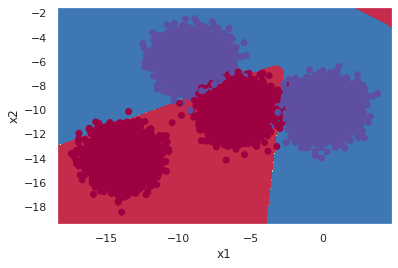

AUC: 0.9999804984210602
MSE: 0.0004504723229133519


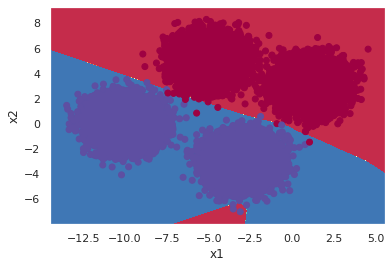

AUC: 0.999960052804413
MSE: 0.0020486675446926995


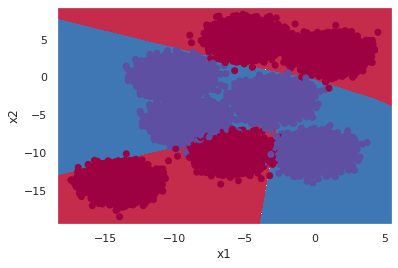

(0.999960052804413, 0.0020486675446926995)

In [62]:
plot_decision_boundary(ewc_net, X_test, y_test)

plot_decision_boundary(ewc_net, X_t2, y_t2)

plot_decision_boundary(ewc_net, np.concatenate([X_test, X_t2]), np.concatenate([y_test, y_t2]))

# BackPack Training

### Note that the approximation to the Fisher Information Matrix above uses the Empirical Fisher approximation, which is known to have some potentially serious flaws when used as a stand in for the Fisher Information Matrix. (see https://papers.nips.cc/paper/2019/file/46a558d97954d0692411c861cf78ef79-Paper.pdf and https://arxiv.org/pdf/1412.1193.pdf for more info)
### Luckily, there exist many efficient methods for a more sound approximation of the Fisher Information Matrix, and a wonderful pytorch package, BackPack, has been created to provide such approximations with some efficient modifications to back-propagation. (see https://openreview.net/pdf?id=BJlrF24twB )

### Below we use BackPack to get the diagonal values of the Fisher Information Matrix, which under some mild conditions is the Generalized Gauss-Newton matrix.

### Not only does BackPack provide more accurate values for the Fisher Information Matrix, it is also faster to calculate!

In [66]:
bp_net = extend(deepcopy(first_net))

optimizer = optim.AdamW(bp_net.parameters())
optimizer.zero_grad()

inputs, labels = torch.Tensor(X_train).cuda(), torch.Tensor(y_train.reshape(-1,1)).cuda()

outputs = bp_net(inputs)
criterion = nn.MSELoss()
criterion = extend(criterion)
loss = criterion(outputs, labels)

with backpack(DiagGGNExact()):
    loss.backward()

for name, param in bp_net.named_parameters():
    print(name)
    print(".diag_ggn_exact.shape:   ", param.diag_ggn_exact.shape)
    print(param.diag_ggn_exact)

total = 0
for name, param in bp_net.named_parameters():
    total += param.diag_ggn_exact.sum()
print(total)

0.weight
.diag_ggn_exact.shape:    torch.Size([20, 2])
tensor([[2.2703e-03, 2.5014e-02],
        [0.0000e+00, 0.0000e+00],
        [1.6252e-01, 1.5339e-01],
        [4.7237e-04, 5.1668e-03],
        [4.5838e-02, 5.6488e-02],
        [0.0000e+00, 0.0000e+00],
        [2.6534e-03, 2.9241e-02],
        [1.2887e-03, 1.4196e-02],
        [0.0000e+00, 0.0000e+00],
        [6.6215e-05, 1.9184e-05],
        [6.0380e-02, 7.5108e-02],
        [0.0000e+00, 0.0000e+00],
        [1.7041e-02, 1.7406e-02],
        [9.8883e-03, 9.2597e-03],
        [0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00],
        [1.8577e-01, 1.7563e-01],
        [3.7213e-01, 3.5165e-01],
        [1.7170e-02, 2.1553e-02],
        [4.4617e-02, 5.2792e-02]], device='cuda:0')
0.bias
.diag_ggn_exact.shape:    torch.Size([20])
tensor([2.4936e-04, 0.0000e+00, 2.3350e-03, 5.1669e-05, 7.8311e-04, 0.0000e+00,
        2.9151e-04, 1.4152e-04, 0.0000e+00, 7.1551e-07, 1.0385e-03, 0.0000e+00,
        2.5701e-04, 1.4197e-04, 0.000

In [67]:
total = 0
for name, param in ewc._precision_matrices.items():
    print(f"{name}, shape: {param.shape}")
    print(param)
    total += param.sum()

0.weight, shape: torch.Size([20, 2])
tensor([[7.8608e-04, 8.3857e-03],
        [0.0000e+00, 0.0000e+00],
        [5.3375e-02, 5.2627e-02],
        [1.6190e-04, 1.7252e-03],
        [1.5115e-02, 1.9264e-02],
        [0.0000e+00, 0.0000e+00],
        [9.1852e-04, 9.7986e-03],
        [4.4614e-04, 4.7593e-03],
        [0.0000e+00, 0.0000e+00],
        [4.9061e-07, 1.4557e-07],
        [1.9844e-02, 2.5577e-02],
        [0.0000e+00, 0.0000e+00],
        [5.6266e-03, 5.9666e-03],
        [3.2079e-03, 3.1594e-03],
        [0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00],
        [6.1181e-02, 6.0310e-02],
        [1.2233e-01, 1.2066e-01],
        [5.6638e-03, 7.3468e-03],
        [1.4719e-02, 1.8022e-02]], device='cuda:0')
0.bias, shape: torch.Size([20])
tensor([8.7515e-05, 0.0000e+00, 8.0417e-04, 1.8013e-05, 2.7076e-04, 0.0000e+00,
        1.0226e-04, 4.9669e-05, 0.0000e+00, 5.2623e-09, 3.5823e-04, 0.0000e+00,
        8.8841e-05, 4.8359e-05, 0.0000e+00, 0.0000e+00, 9.2138e-04, 1.843

### In this case, the performance is comparable to using the Empirical Information Matrix in the EWC regularization term. Note there is slightly better perfromance is maintained on the first data set.

  5%|▌         | 1/20 [00:01<00:28,  1.48s/it]

tensor(0.1439, device='cuda:0', grad_fn=<DivBackward0>)


 10%|█         | 2/20 [00:02<00:26,  1.46s/it]

tensor(0.0061, device='cuda:0', grad_fn=<DivBackward0>)


 15%|█▌        | 3/20 [00:04<00:24,  1.45s/it]

tensor(0.0033, device='cuda:0', grad_fn=<DivBackward0>)


 20%|██        | 4/20 [00:05<00:23,  1.45s/it]

tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)


 25%|██▌       | 5/20 [00:07<00:22,  1.47s/it]

tensor(0.0019, device='cuda:0', grad_fn=<DivBackward0>)


 30%|███       | 6/20 [00:08<00:21,  1.50s/it]

tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)


 35%|███▌      | 7/20 [00:10<00:19,  1.49s/it]

tensor(0.0016, device='cuda:0', grad_fn=<DivBackward0>)


 40%|████      | 8/20 [00:11<00:17,  1.49s/it]

tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)


 45%|████▌     | 9/20 [00:13<00:16,  1.50s/it]

tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>)


 50%|█████     | 10/20 [00:14<00:14,  1.50s/it]

tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)


 55%|█████▌    | 11/20 [00:16<00:13,  1.48s/it]

tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>)


 60%|██████    | 12/20 [00:17<00:11,  1.46s/it]

tensor(0.0006, device='cuda:0', grad_fn=<DivBackward0>)


 65%|██████▌   | 13/20 [00:19<00:10,  1.52s/it]

tensor(0.0005, device='cuda:0', grad_fn=<DivBackward0>)


 70%|███████   | 14/20 [00:20<00:09,  1.51s/it]

tensor(0.0005, device='cuda:0', grad_fn=<DivBackward0>)


 75%|███████▌  | 15/20 [00:22<00:07,  1.50s/it]

tensor(0.0004, device='cuda:0', grad_fn=<DivBackward0>)


 80%|████████  | 16/20 [00:23<00:06,  1.53s/it]

tensor(0.0004, device='cuda:0', grad_fn=<DivBackward0>)


 85%|████████▌ | 17/20 [00:25<00:04,  1.55s/it]

tensor(0.0004, device='cuda:0', grad_fn=<DivBackward0>)


 90%|█████████ | 18/20 [00:26<00:03,  1.52s/it]

tensor(0.0004, device='cuda:0', grad_fn=<DivBackward0>)


 95%|█████████▌| 19/20 [00:28<00:01,  1.51s/it]

tensor(0.0004, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 20/20 [00:29<00:00,  1.50s/it]

tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
AUC: 0.9999651746089903
MSE: 0.0020324711269408347


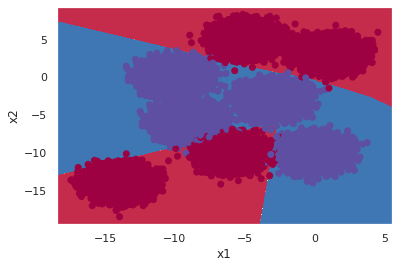

AUC: 0.9999924925001323
MSE: 0.00043554531029992136


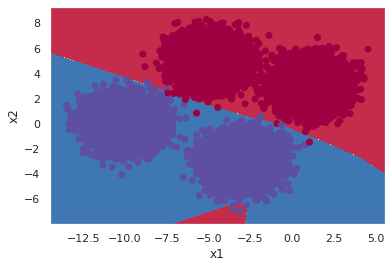

AUC: 0.9999033689403236
MSE: 0.0036293969435817475


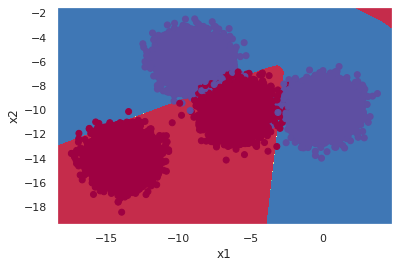

(0.9999033689403236, 0.0036293969435817475)

In [69]:
gnc = deepcopy(ewc)

for name, param in bp_net.named_parameters():
    gnc._precision_matrices[name] = param.diag_ggn_exact
    
gnc_net = deepcopy(first_net)

optimizer = optim.AdamW(gnc_net.parameters())

data_loader2 = torch.utils.data.DataLoader(get_tensor_dataset(X_tr2, y_tr2), batch_size = 256,
                                          shuffle = True, num_workers = 2)

for _ in tqdm(range(20)):
    loss = ewc_train(gnc_net, optimizer, data_loader2, gnc, 1000 / 2.817371548409647)
    print(loss)

plot_decision_boundary(gnc_net, np.concatenate([X_test, X_t2]), np.concatenate([y_test, y_t2]))

plot_decision_boundary(gnc_net, X_t2, y_t2)

plot_decision_boundary(gnc_net, X_test, y_test)

# Different data

### Now we will use a different initial data set. It is more similar to the second data set, but crucially there is one blob in group 1 that is very different from the group 1 blobs in the second data set.

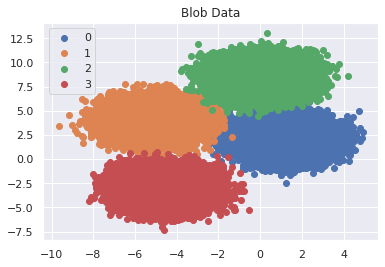

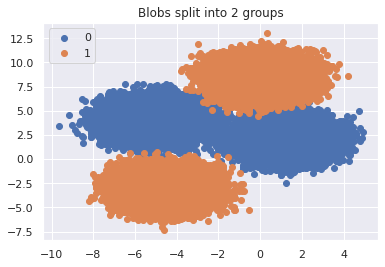

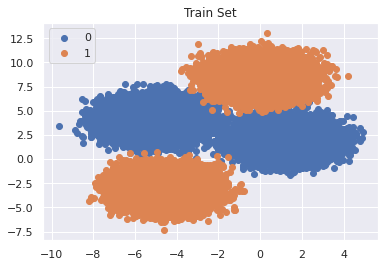

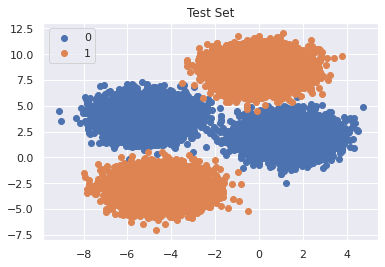

In [86]:
#[[1,3],[-5,5],[-3,-3],[-10,0]]
X_train, X_test, y_train, y_test = get_binary_blobs(centers = [[1.2,2],[-5.2,4],[0,8.5],[-4.5,-3]])

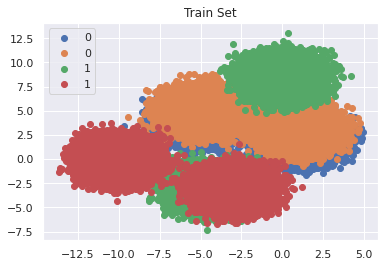

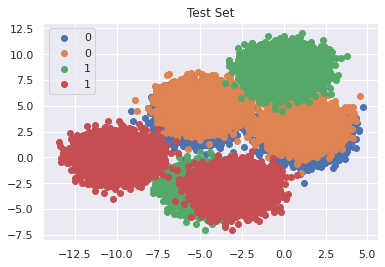

In [87]:
for i in range(2):
    plt.scatter(X_train[y_train == i,0], X_train[y_train == i,1], label = i)
    plt.scatter(X_tr2[y_tr2 == i,0], X_tr2[y_tr2 == i,1], label = i)
plt.title("Train Set")
plt.legend()
plt.show()

for i in range(2):
    plt.scatter(X_test[y_test == i,0], X_test[y_test == i,1], label = i)
    plt.scatter(X_t2[y_t2 == i,0], X_t2[y_t2 == i,1], label = i)
plt.title("Test Set")
plt.legend()
plt.show()

In [88]:
def get_tensor_dataset(X, y):
    y = y.reshape(-1,1)
    return TensorDataset(torch.Tensor(X), torch.Tensor(y))

def train_model(X, y, model = None, optimizer = None):
    if model is None:
        model = nn.Sequential(
                nn.Linear(2, 20),
                nn.ReLU(),
                nn.Linear(20, 10),
                nn.ReLU(),
                nn.Linear(10, 1),
                nn.Sigmoid())
    
    use_gpu = torch.cuda.is_available()
    
    if use_gpu:
        model.cuda()

    batch_size = 256
    data_loader = torch.utils.data.DataLoader(get_tensor_dataset(X, y), batch_size = batch_size,
                                          shuffle = True, num_workers = 2)
    
    criterion = nn.MSELoss()
    
    if optimizer is None:
        optimizer = optim.AdamW(model.parameters())
    
    for epoch in range(20):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(data_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

        print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss / 2000))

    print('Finished Training')
    
    return model

def train_then_plot(X, y, model = None, optimizer = None):
    start = time.perf_counter()
    net = train_model(X, y, model, optimizer)
    stop = time.perf_counter()
    print(f"Train time: {stop - start} sec")
    plot_decision_boundary(net, X_test, y_test)
    plot_decision_boundary(net, X_t2, y_t2)
    plot_decision_boundary(net, np.concatenate([X_test, X_t2]), np.concatenate([y_test, y_t2]))
    return net

# Initial Training

[1,   293] loss: 0.020
[2,   293] loss: 0.005
[3,   293] loss: 0.003
[4,   293] loss: 0.002
[5,   293] loss: 0.002
[6,   293] loss: 0.001
[7,   293] loss: 0.001
[8,   293] loss: 0.001
[9,   293] loss: 0.001
[10,   293] loss: 0.001
[11,   293] loss: 0.000
[12,   293] loss: 0.000
[13,   293] loss: 0.000
[14,   293] loss: 0.000
[15,   293] loss: 0.000
[16,   293] loss: 0.000
[17,   293] loss: 0.000
[18,   293] loss: 0.000
[19,   293] loss: 0.000
[20,   293] loss: 0.000
Finished Training
Train time: 22.26441274996614 sec
AUC: 0.9999582831337284
MSE: 0.0010092830425633824


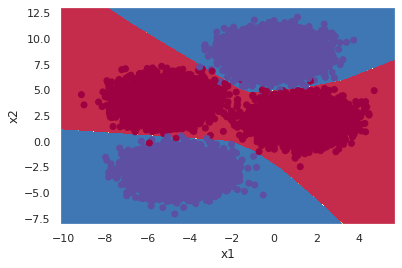

AUC: 0.9923696664261643
MSE: 0.031055009202714368


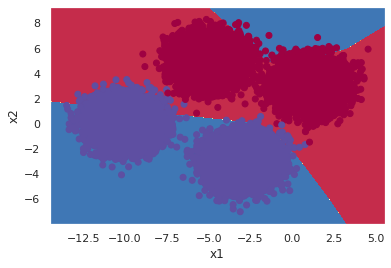

AUC: 0.9974030786727295
MSE: 0.016032146122638875


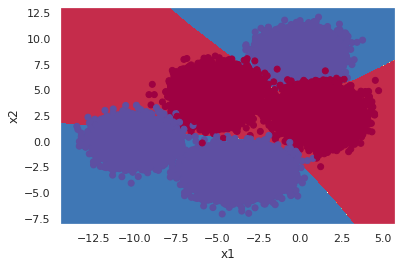

In [89]:
first_net = train_then_plot(X_train, y_train)

# Naive Transfer Learning

### Naive transfer learning appears to do much better in this scenario, but it still completely miscatogarizes an entire blob in the first data set.

[1,   293] loss: 0.000
[2,   293] loss: 0.000
[3,   293] loss: 0.000
[4,   293] loss: 0.000
[5,   293] loss: 0.000
[6,   293] loss: 0.000
[7,   293] loss: 0.000
[8,   293] loss: 0.000
[9,   293] loss: 0.000
[10,   293] loss: 0.000
[11,   293] loss: 0.000
[12,   293] loss: 0.000
[13,   293] loss: 0.000
[14,   293] loss: 0.000
[15,   293] loss: 0.000
[16,   293] loss: 0.000
[17,   293] loss: 0.000
[18,   293] loss: 0.000
[19,   293] loss: 0.000
[20,   293] loss: 0.000
Finished Training
Train time: 21.213494356023148 sec
AUC: 0.9842849371026717
MSE: 0.23103955867861467


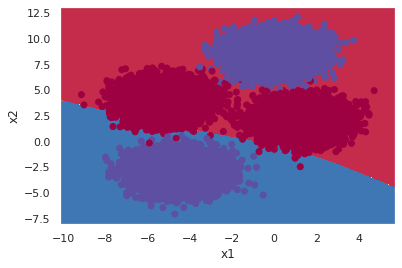

AUC: 0.9999992255690673
MSE: 0.0002769709656629778


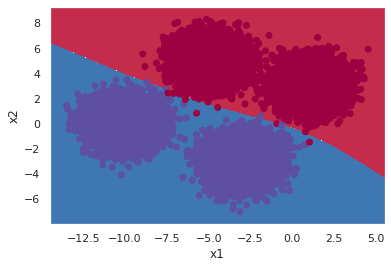

AUC: 0.9956107550830239
MSE: 0.11565826482213883


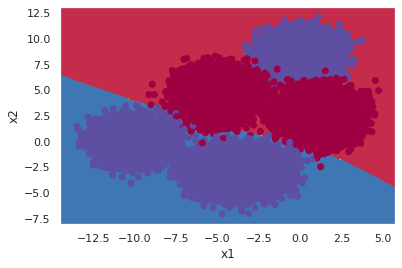

In [90]:
first_transfer_net = train_then_plot(X_tr2, y_tr2, copy.deepcopy(first_net))

# Second Training

### Training only on the second data set does worse in all ways compared to the naive transfer learned network.

[1,   293] loss: 0.009
[2,   293] loss: 0.000
[3,   293] loss: 0.000
[4,   293] loss: 0.000
[5,   293] loss: 0.000
[6,   293] loss: 0.000
[7,   293] loss: 0.000
[8,   293] loss: 0.000
[9,   293] loss: 0.000
[10,   293] loss: 0.000
[11,   293] loss: 0.000
[12,   293] loss: 0.000
[13,   293] loss: 0.000
[14,   293] loss: 0.000
[15,   293] loss: 0.000
[16,   293] loss: 0.000
[17,   293] loss: 0.000
[18,   293] loss: 0.000
[19,   293] loss: 0.000
[20,   293] loss: 0.000
Finished Training
Train time: 20.488087114004884 sec
AUC: 0.49063730603153255
MSE: 0.25584387766103517


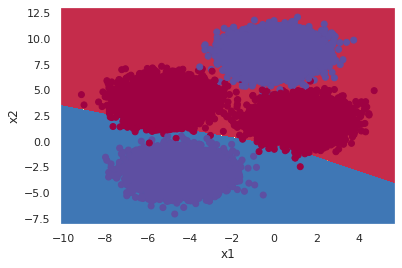

AUC: 0.9999983359335332
MSE: 0.00030818904237691193


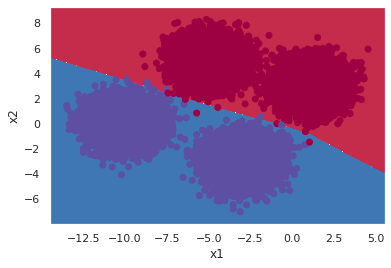

AUC: 0.745353191195304
MSE: 0.12807603335170606


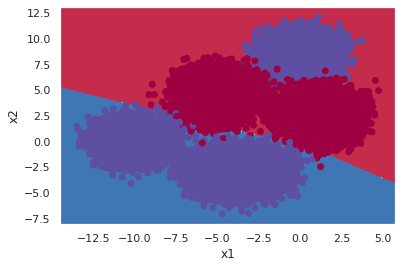

In [91]:
second_net = train_then_plot(X_tr2, y_tr2)

# Combined Data Training

[1,   586] loss: 0.016
[2,   586] loss: 0.001
[3,   586] loss: 0.001
[4,   586] loss: 0.001
[5,   586] loss: 0.001
[6,   586] loss: 0.000
[7,   586] loss: 0.000
[8,   586] loss: 0.000
[9,   586] loss: 0.000
[10,   586] loss: 0.000
[11,   586] loss: 0.000
[12,   586] loss: 0.000
[13,   586] loss: 0.000
[14,   586] loss: 0.000
[15,   586] loss: 0.000
[16,   586] loss: 0.000
[17,   586] loss: 0.000
[18,   586] loss: 0.000
[19,   586] loss: 0.000
[20,   586] loss: 0.000
Finished Training
Train time: 37.339831687975675 sec
AUC: 0.9999708468355526
MSE: 0.0010313989431573075


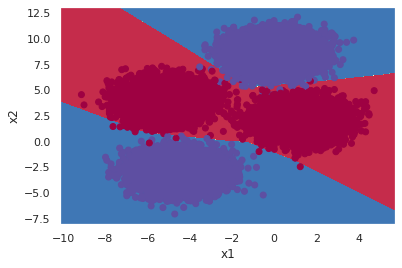

AUC: 0.9999828473148805
MSE: 0.0013917574757964664


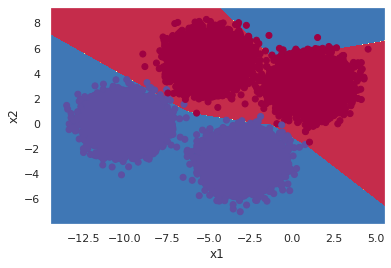

AUC: 0.9999789351586197
MSE: 0.0012115782094768868


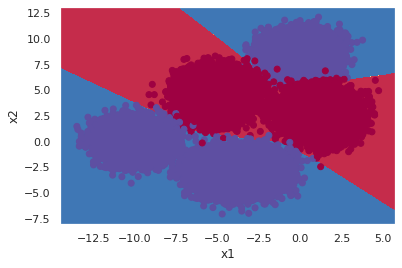

In [92]:
both_net = train_then_plot(np.concatenate([X_train, X_tr2]), np.concatenate([y_train, y_tr2]))

# Transfer Learning w/ Slow Learning Rate

[1,   293] loss: 0.003
[2,   293] loss: 0.001
[3,   293] loss: 0.001
[4,   293] loss: 0.001
[5,   293] loss: 0.000
[6,   293] loss: 0.000
[7,   293] loss: 0.000
[8,   293] loss: 0.000
[9,   293] loss: 0.000
[10,   293] loss: 0.000
[11,   293] loss: 0.000
[12,   293] loss: 0.000
[13,   293] loss: 0.000
[14,   293] loss: 0.000
[15,   293] loss: 0.000
[16,   293] loss: 0.000
[17,   293] loss: 0.000
[18,   293] loss: 0.000
[19,   293] loss: 0.000
[20,   293] loss: 0.000
Finished Training
Train time: 21.29868958896259 sec
AUC: 0.9991188832060806
MSE: 0.006982576232189525


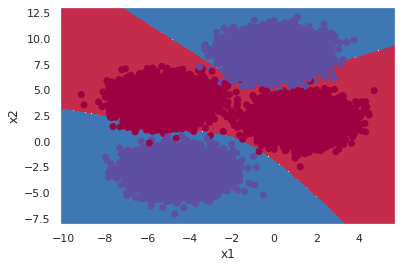

AUC: 0.9999670386834459
MSE: 0.001056342502506407


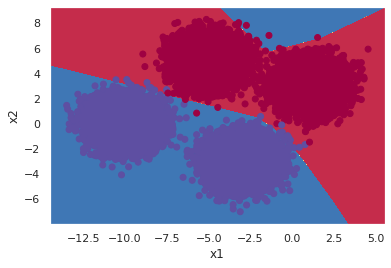

AUC: 0.9997375103155322
MSE: 0.004019459367347966


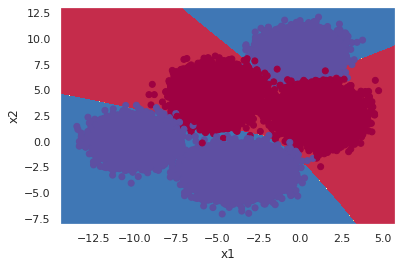

In [93]:
copy_first = copy.deepcopy(first_net)
slow_sgd = optim.SGD(copy_first.parameters(), weight_decay = 0.01, lr = 0.001)
slow_transfer = train_then_plot(X_tr2, y_tr2, copy_first, slow_sgd)

# Freezing the Weights

### According to the metrics freezing the weights does reasonably well. However, note that thecontour plots show that the network output is skewed quite a bit, such that it appears to completely miss one of the blobs in the first data set. This is partly because the plotting script rounds to 0 and 1 to generate the contours. Overall the ordering of the netwrok outputs gives good perfomance, but the calibration is a bit off.

[1,   293] loss: 0.003
[2,   293] loss: 0.001
[3,   293] loss: 0.001
[4,   293] loss: 0.001
[5,   293] loss: 0.001
[6,   293] loss: 0.001
[7,   293] loss: 0.001
[8,   293] loss: 0.000
[9,   293] loss: 0.000
[10,   293] loss: 0.000
[11,   293] loss: 0.000
[12,   293] loss: 0.000
[13,   293] loss: 0.000
[14,   293] loss: 0.000
[15,   293] loss: 0.000
[16,   293] loss: 0.000
[17,   293] loss: 0.000
[18,   293] loss: 0.000
[19,   293] loss: 0.000
[20,   293] loss: 0.000
Finished Training
Train time: 18.087555610982236 sec
AUC: 0.9961538879770552
MSE: 0.07607200956847691


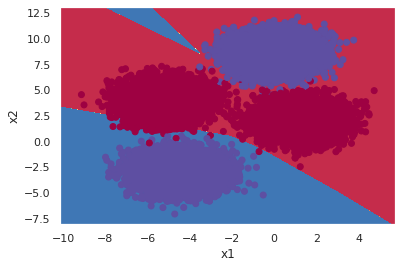

AUC: 0.9999488811581907
MSE: 0.0008587206878643327


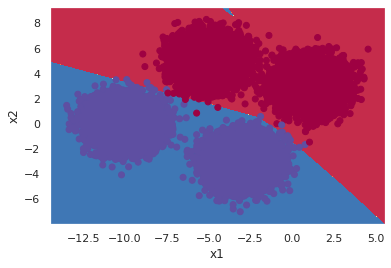

AUC: 0.9989282731926592
MSE: 0.03846536512817063


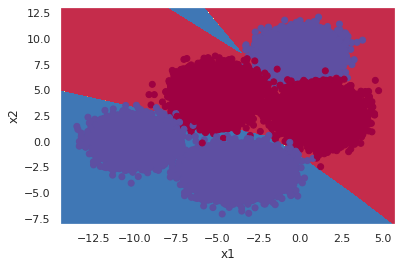

In [94]:
copy_first = copy.deepcopy(first_net)
for name, param in copy_first.named_parameters():
    if name in ["0.weight", "0.bias", "2.weight", "2.bias"]:
        param.requires_grad = False
freeze_first_optimizer = optim.AdamW(copy_first.parameters())
freeze_first_transfer = train_then_plot(X_tr2, y_tr2, copy_first, freeze_first_optimizer)

# EWC

### EWC shows better performance pictorially and numerically, with the exception that it doesn't do quite as well on the second data set as freezing the weights, but it does provide better overall performance.

In [95]:
data_loader = torch.utils.data.DataLoader(get_tensor_dataset(X_train, y_train), batch_size = 256,
                                          shuffle = True, num_workers = 2)

data_loader2 = torch.utils.data.DataLoader(get_tensor_dataset(X_tr2, y_tr2), batch_size = 256,
                                          shuffle = True, num_workers = 2)

ewc = EWC(first_net, data_loader.dataset)

ewc_net = deepcopy(first_net)

optimizer = optim.AdamW(ewc_net.parameters())

for _ in tqdm(range(20)):
    loss = ewc_train(ewc_net, optimizer, data_loader2, ewc, 1000)
    print(loss)

  5%|▌         | 1/20 [00:01<00:27,  1.43s/it]

tensor(0.0085, device='cuda:0', grad_fn=<DivBackward0>)


 10%|█         | 2/20 [00:02<00:25,  1.43s/it]

tensor(0.0066, device='cuda:0', grad_fn=<DivBackward0>)


 15%|█▌        | 3/20 [00:04<00:24,  1.44s/it]

tensor(0.0064, device='cuda:0', grad_fn=<DivBackward0>)


 20%|██        | 4/20 [00:05<00:22,  1.44s/it]

tensor(0.0064, device='cuda:0', grad_fn=<DivBackward0>)


 25%|██▌       | 5/20 [00:07<00:21,  1.44s/it]

tensor(0.0063, device='cuda:0', grad_fn=<DivBackward0>)


 30%|███       | 6/20 [00:08<00:19,  1.42s/it]

tensor(0.0062, device='cuda:0', grad_fn=<DivBackward0>)


 35%|███▌      | 7/20 [00:10<00:18,  1.43s/it]

tensor(0.0061, device='cuda:0', grad_fn=<DivBackward0>)


 40%|████      | 8/20 [00:11<00:17,  1.43s/it]

tensor(0.0060, device='cuda:0', grad_fn=<DivBackward0>)


 45%|████▌     | 9/20 [00:12<00:15,  1.42s/it]

tensor(0.0060, device='cuda:0', grad_fn=<DivBackward0>)


 50%|█████     | 10/20 [00:14<00:14,  1.42s/it]

tensor(0.0059, device='cuda:0', grad_fn=<DivBackward0>)


 55%|█████▌    | 11/20 [00:15<00:12,  1.44s/it]

tensor(0.0058, device='cuda:0', grad_fn=<DivBackward0>)


 60%|██████    | 12/20 [00:17<00:11,  1.42s/it]

tensor(0.0057, device='cuda:0', grad_fn=<DivBackward0>)


 65%|██████▌   | 13/20 [00:18<00:10,  1.43s/it]

tensor(0.0056, device='cuda:0', grad_fn=<DivBackward0>)


 70%|███████   | 14/20 [00:20<00:08,  1.43s/it]

tensor(0.0055, device='cuda:0', grad_fn=<DivBackward0>)


 75%|███████▌  | 15/20 [00:21<00:07,  1.44s/it]

tensor(0.0055, device='cuda:0', grad_fn=<DivBackward0>)


 80%|████████  | 16/20 [00:22<00:05,  1.43s/it]

tensor(0.0054, device='cuda:0', grad_fn=<DivBackward0>)


 85%|████████▌ | 17/20 [00:24<00:04,  1.44s/it]

tensor(0.0053, device='cuda:0', grad_fn=<DivBackward0>)


 90%|█████████ | 18/20 [00:25<00:02,  1.44s/it]

tensor(0.0053, device='cuda:0', grad_fn=<DivBackward0>)


 95%|█████████▌| 19/20 [00:27<00:01,  1.44s/it]

tensor(0.0053, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 20/20 [00:28<00:00,  1.43s/it]

tensor(0.0052, device='cuda:0', grad_fn=<DivBackward0>)


AUC: 0.9999139421626434
MSE: 0.0027685582894176144


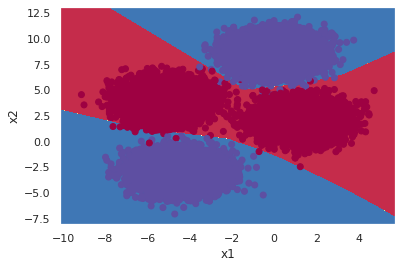

AUC: 0.9999145309861626
MSE: 0.00248756959351097


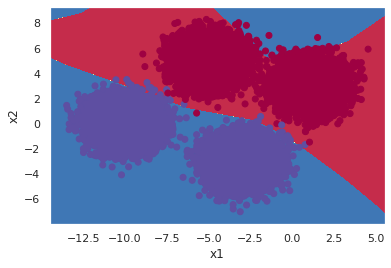

AUC: 0.9999287491540702
MSE: 0.0026280639414642923


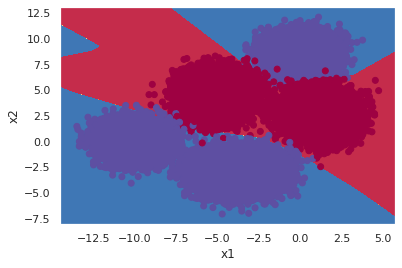

(0.9999287491540702, 0.0026280639414642923)

In [96]:
plot_decision_boundary(ewc_net, X_test, y_test)

plot_decision_boundary(ewc_net, X_t2, y_t2)

plot_decision_boundary(ewc_net, np.concatenate([X_test, X_t2]), np.concatenate([y_test, y_t2]))

# BackPack

### The BackPack Fisher Information Matrix shows the best overall performance (excluding the network trained on all data).

  5%|▌         | 1/20 [00:01<00:26,  1.41s/it]

tensor(0.0092, device='cuda:0', grad_fn=<DivBackward0>)


 10%|█         | 2/20 [00:02<00:25,  1.41s/it]

tensor(0.0074, device='cuda:0', grad_fn=<DivBackward0>)


 15%|█▌        | 3/20 [00:04<00:24,  1.42s/it]

tensor(0.0073, device='cuda:0', grad_fn=<DivBackward0>)


 20%|██        | 4/20 [00:05<00:22,  1.43s/it]

tensor(0.0072, device='cuda:0', grad_fn=<DivBackward0>)


 25%|██▌       | 5/20 [00:07<00:21,  1.44s/it]

tensor(0.0071, device='cuda:0', grad_fn=<DivBackward0>)


 30%|███       | 6/20 [00:08<00:20,  1.44s/it]

tensor(0.0070, device='cuda:0', grad_fn=<DivBackward0>)


 35%|███▌      | 7/20 [00:10<00:18,  1.45s/it]

tensor(0.0070, device='cuda:0', grad_fn=<DivBackward0>)


 40%|████      | 8/20 [00:11<00:17,  1.45s/it]

tensor(0.0069, device='cuda:0', grad_fn=<DivBackward0>)


 45%|████▌     | 9/20 [00:12<00:15,  1.44s/it]

tensor(0.0068, device='cuda:0', grad_fn=<DivBackward0>)


 50%|█████     | 10/20 [00:14<00:14,  1.43s/it]

tensor(0.0067, device='cuda:0', grad_fn=<DivBackward0>)


 55%|█████▌    | 11/20 [00:15<00:12,  1.43s/it]

tensor(0.0066, device='cuda:0', grad_fn=<DivBackward0>)


 60%|██████    | 12/20 [00:17<00:11,  1.43s/it]

tensor(0.0066, device='cuda:0', grad_fn=<DivBackward0>)


 65%|██████▌   | 13/20 [00:18<00:09,  1.42s/it]

tensor(0.0065, device='cuda:0', grad_fn=<DivBackward0>)


 70%|███████   | 14/20 [00:20<00:08,  1.43s/it]

tensor(0.0064, device='cuda:0', grad_fn=<DivBackward0>)


 75%|███████▌  | 15/20 [00:21<00:07,  1.43s/it]

tensor(0.0063, device='cuda:0', grad_fn=<DivBackward0>)


 80%|████████  | 16/20 [00:22<00:05,  1.43s/it]

tensor(0.0062, device='cuda:0', grad_fn=<DivBackward0>)


 85%|████████▌ | 17/20 [00:24<00:04,  1.45s/it]

tensor(0.0062, device='cuda:0', grad_fn=<DivBackward0>)


 90%|█████████ | 18/20 [00:25<00:02,  1.44s/it]

tensor(0.0061, device='cuda:0', grad_fn=<DivBackward0>)


 95%|█████████▌| 19/20 [00:27<00:01,  1.45s/it]

tensor(0.0061, device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 20/20 [00:28<00:00,  1.44s/it]

tensor(0.0060, device='cuda:0', grad_fn=<DivBackward0>)
AUC: 0.9998938301593217
MSE: 0.002386426454601427


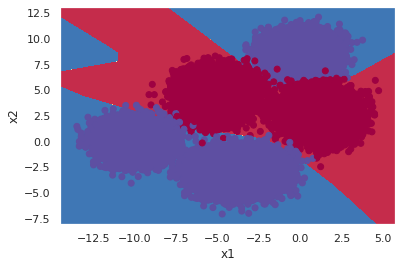

AUC: 0.9998166518766359
MSE: 0.003215518680072205


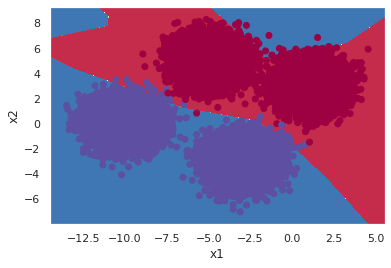

AUC: 0.9999156382303885
MSE: 0.0015573342291306485


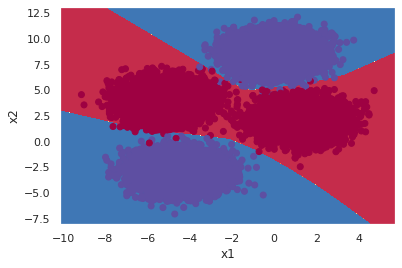

(0.9999156382303885, 0.0015573342291306485)

In [97]:
bp_net = extend(deepcopy(first_net))

optimizer = optim.AdamW(bp_net.parameters())
optimizer.zero_grad()

inputs, labels = torch.Tensor(X_train).cuda(), torch.Tensor(y_train.reshape(-1,1)).cuda()

outputs = bp_net(inputs)
criterion = nn.MSELoss()
criterion = extend(criterion)
loss = criterion(outputs, labels)

with backpack(DiagGGNExact()):
    loss.backward()
    
gnc = deepcopy(ewc)

for name, param in bp_net.named_parameters():
    gnc._precision_matrices[name] = param.diag_ggn_exact
    
gnc_net = deepcopy(first_net)

optimizer = optim.AdamW(gnc_net.parameters())

data_loader2 = torch.utils.data.DataLoader(get_tensor_dataset(X_tr2, y_tr2), batch_size = 256,
                                          shuffle = True, num_workers = 2)

for _ in tqdm(range(20)):
    loss = ewc_train(gnc_net, optimizer, data_loader2, gnc, 1000 / 2.817371548409647)
    print(loss)

plot_decision_boundary(gnc_net, np.concatenate([X_test, X_t2]), np.concatenate([y_test, y_t2]))

plot_decision_boundary(gnc_net, X_t2, y_t2)

plot_decision_boundary(gnc_net, X_test, y_test)